In [33]:
from seriesNet_torch import *
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import torch
import random
import glob
from action_500FN import action, load_dataset
import matplotlib.pyplot as plt
import fn_500_dataset
from fn_500_dataset import ActionDataset
from torch.utils.data import DataLoader
import importlib

In [35]:
myModel = seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=3)
print(myModel)

seriesNet(
  (module_block): ModuleList(
    (0): gated_block(
      (pad_input): ReflectionPad1d((1, 0))
      (conv): Conv1d(5, 16, kernel_size=(2,), stride=(1,), bias=False, padding_mode=reflect)
      (network_in): Conv1d(16, 5, kernel_size=(1,), stride=(1,), bias=False)
      (skipout): Conv1d(16, 5, kernel_size=(1,), stride=(1,), bias=False)
    )
    (1): gated_block(
      (pad_input): ReflectionPad1d((2, 0))
      (conv): Conv1d(5, 16, kernel_size=(2,), stride=(1,), dilation=(2,), bias=False, padding_mode=reflect)
      (network_in): Conv1d(16, 5, kernel_size=(1,), stride=(1,), bias=False)
      (skipout): Conv1d(16, 5, kernel_size=(1,), stride=(1,), bias=False)
    )
    (2): gated_block(
      (pad_input): ReflectionPad1d((4, 0))
      (conv): Conv1d(5, 16, kernel_size=(2,), stride=(1,), dilation=(4,), bias=False, padding_mode=reflect)
      (network_in): Conv1d(16, 5, kernel_size=(1,), stride=(1,), bias=False)
      (skipout): Conv1d(16, 5, kernel_size=(1,), stride=(1,), bi

In [36]:
importlib.reload(fn_500_dataset)
dataset = fn_500_dataset.ActionDataset(".\\individual_stocks_5yr/", normalise=True)
dataset_train, data_test = dataset[0:400].float(), dataset[400:].float() #torch.utils.data.random_split(dataset, [400,70])
print(len(dataset))
print(len(dataset_train))
print(len(data_test))
training_loader = DataLoader(dataset_train, batch_size=10, shuffle=False, drop_last=False)

lenght :  470
torch.Size([470, 5, 1259])
470
400
70


epoch 0


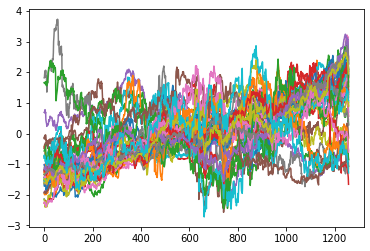

In [37]:
myModel = seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2)
#myModel = myModel.float()
dataset.float()
# CHOISIR UNE LOSS
criterion = nn.MSELoss()
optimizer = optim.SGD(myModel.parameters(), lr=0.0001, weight_decay=0.01)
#choice = torch.multinomial(torch.tensor(np.arange(data.size()[0])).float(), 1)
for i in range(1):
    print('epoch {}'.format(i))
    for i,batch in enumerate(training_loader):
        #print("batch s{}".format(i))
        inputModel, target = batch[:,:,:-1], batch[:,:,1:]
        plt.plot(inputModel[0,2])

In [38]:
dataset = fn_500_dataset.ActionDataset(".\\individual_stocks_5yr/", normalise=True)
dataset.float()
dataset_train, dataset_validation = torch.utils.data.random_split(dataset, (400, 70))
print(len(dataset))
print(len(dataset_train))
print(len(dataset_validation))
training_loader = DataLoader(dataset_train, batch_size=10, shuffle=True, drop_last=False)
valid_loader = DataLoader(dataset_validation, batch_size=10, shuffle=True, drop_last=False)

lenght :  470
torch.Size([470, 5, 1259])
470
400
70


In [39]:
# LES DATA DOIVENT ETRE DE LA FORME (N, C, TIMESERIES) OU N EST LE NOMBRE D'ELEMENTS DANS LA MINI BATCH
# C LE NOMBRE DE CANAUX, ET TIMESERIES LE NOMBRE DE POINTS DANS LA SERIE CHRONOLOGIQUE
# INITIALISER LE MODELE :
myModel = seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2)
myModel = myModel.float()
#dataset.float()
# CHOISIR UNE LOSS
criterion = nn.MSELoss()
optimizer = optim.SGD(myModel.parameters(), lr=0.001, weight_decay=0.01)
# TRACE DES METRICS
training_loss_epoch = []
valid_loss_epoch = []
#choice = torch.multinomial(torch.tensor(np.arange(data.size()[0])).float(), 1)
for i in range(20):
    print('epoch {}'.format(i+1))
    training_loss = []
    for j,batch in enumerate(training_loader):
        inputModel, target = batch[:,:,:-1], batch[:,:,1:]
        output = myModel(inputModel)
        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        #print(" loss : ", loss)
        optimizer.step()
        training_loss.append(loss.item())
        #print(training_loss)
    training_loss_epoch.append(np.mean(training_loss))
    myModel.eval()
    with torch.no_grad():
        valid_loss=[]
        for batch in valid_loader:
            inputModel, target = batch[:,:,:-1], batch[:,:,1:]
            output = myModel(inputModel)
            loss = criterion(output, target)
            valid_loss.append(loss.item())
        valid_loss_epoch.append(np.mean(valid_loss))
    print('Validation loss %.3f' % (valid_loss_epoch[-1]))

epoch 1
Validation loss 0.868
epoch 2
Validation loss 0.830
epoch 3
Validation loss 0.791
epoch 4
Validation loss 0.755
epoch 5
Validation loss 0.719
epoch 6
Validation loss 0.684
epoch 7
Validation loss 0.649
epoch 8
Validation loss 0.614
epoch 9
Validation loss 0.580
epoch 10
Validation loss 0.548
epoch 11
Validation loss 0.517
epoch 12
Validation loss 0.489
epoch 13
Validation loss 0.464
epoch 14
Validation loss 0.442
epoch 15
Validation loss 0.423
epoch 16
Validation loss 0.406
epoch 17
Validation loss 0.392
epoch 18
Validation loss 0.379
epoch 19
Validation loss 0.367
epoch 20
Validation loss 0.356


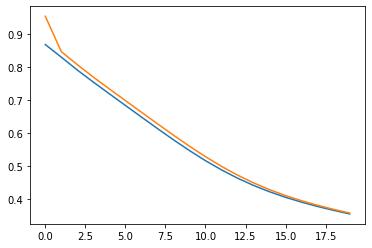

In [40]:
plt.plot(valid_loss_epoch)
plt.plot(training_loss_epoch)

In [31]:
# LES DATA DOIVENT ETRE DE LA FORME (N, C, TIMESERIES) OU N EST LE NOMBRE D'ELEMENTS DANS LA MINI BATCH
# C LE NOMBRE DE CANAUX, ET TIMESERIES LE NOMBRE DE POINTS DANS LA SERIE CHRONOLOGIQUE
#print(CC.size())
# SEPARER LES CIBLES DE L'OUTPUT
data = AA[:,:,:-1].float()

target = AA[:,:,1:].float()

N = 10
# INITIALISER LE MODELE :
myModel = seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=3)
myModel = myModel.float()

# CHOISIR UNE LOSS
criterion = nn.MSELoss()
optimizer = optim.SGD(myModel.parameters(), lr=0.001, weight_decay=0.01)
#choice = torch.multinomial(torch.tensor(np.arange(data.size()[0])).float(), 1)
for i in range(100):
    choice = torch.multinomial(torch.tensor(np.arange(data.size()[0])).float(), N)
    output = myModel(data[choice])
    optimizer.zero_grad()
    
    loss = criterion(output, target[choice])  
    #print(" loss : ", loss)
    loss.backward()
    #print(myModel.conv_final.weight.grad)
    #print("test 2 ")
    #print(myModel.gated_block2.conv.weight.grad)
    optimizer.step()

